# Multi-Human Parsing Visualization

In [1]:
import os
import logging
from tqdm import tqdm
import numpy as np
import argparse
import time
import sys

import mxnet as mx
from mxnet import gluon, ndarray as nd
from mxnet.gluon.data.vision import transforms
from mxnet.contrib.quantization import *

import gluoncv
gluoncv.utils.check_version('0.6.0')
from gluoncv.model_zoo.segbase import *
from gluoncv.model_zoo import get_model
from gluoncv.data import get_segmentation_dataset, ms_batchify_fn
from gluoncv.utils.viz import get_color_pallete
from gluoncv.utils.parallel import *

In [8]:
dataset = 'mhp'
batch_size = 1
workers = 48

## Visualization
Now let's create some helper functions for decoding and visualizing the results.

In [3]:
%matplotlib inline
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
from PIL import Image
from gluoncv.utils.viz.segmentation import mhppallete

In [4]:
colormap = np.array(mhppallete).reshape(-1, 3)
LABEL_NAMES = np.asarray([
    'Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants',
    'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm',
    'Right-arm', 'Bag', 'Scarf', 'Torso-skin'])
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = colormap[FULL_LABEL_MAP]

def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = get_color_pallete(seg_map, 'mhp')
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.show()

## Prepare the Image

In [5]:
from gluoncv.utils.viz import DeNormalize

In [6]:
# image transform
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

testset = get_segmentation_dataset(dataset, split='val', mode='testval', transform=input_transform)
test_data = gluon.data.DataLoader(testset, batch_size, shuffle=False, 
                                  last_batch='rollover', num_workers=workers)

/home/ubuntu/anaconda3/envs/mhp/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


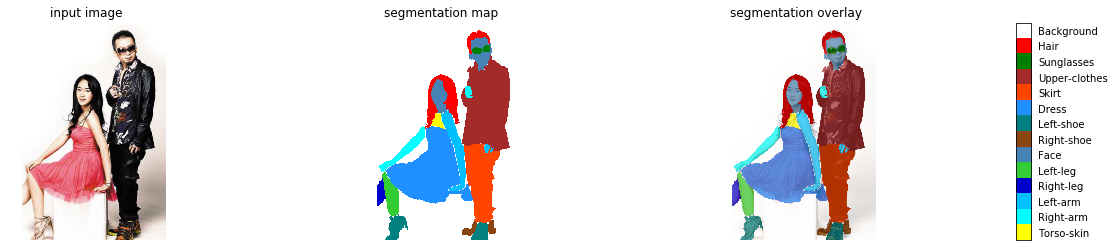

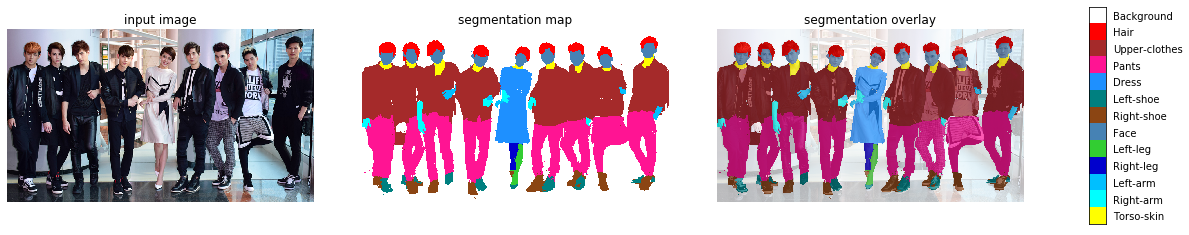

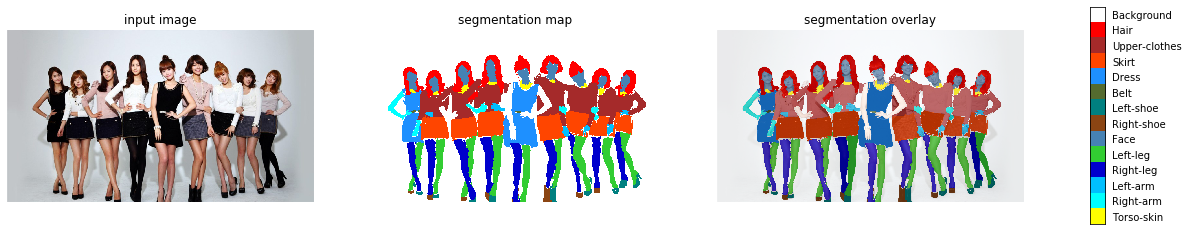

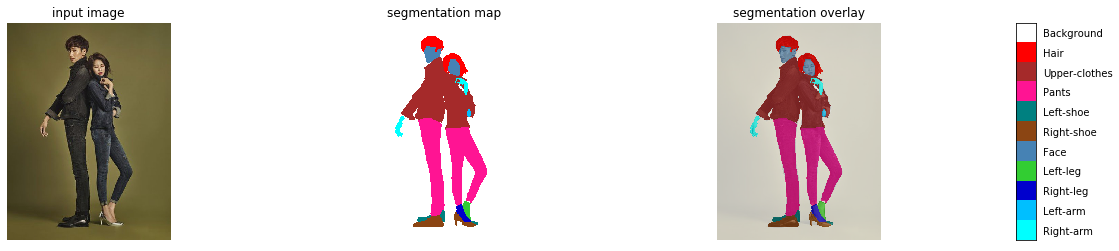

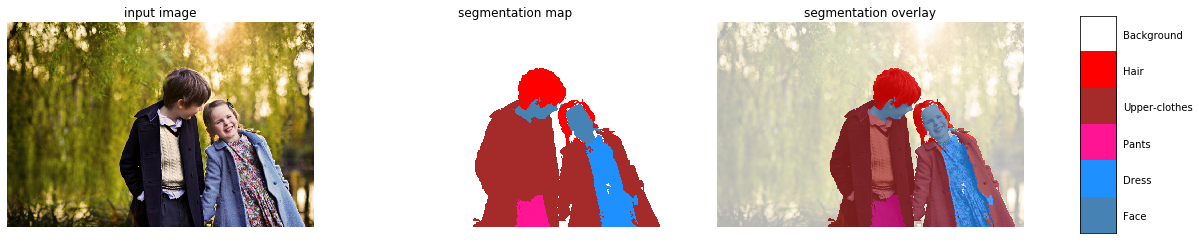

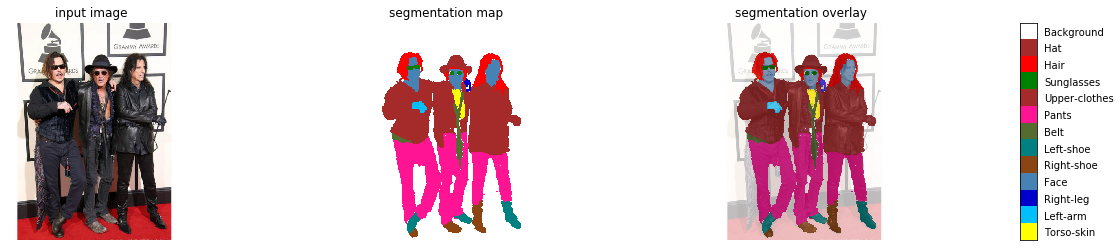

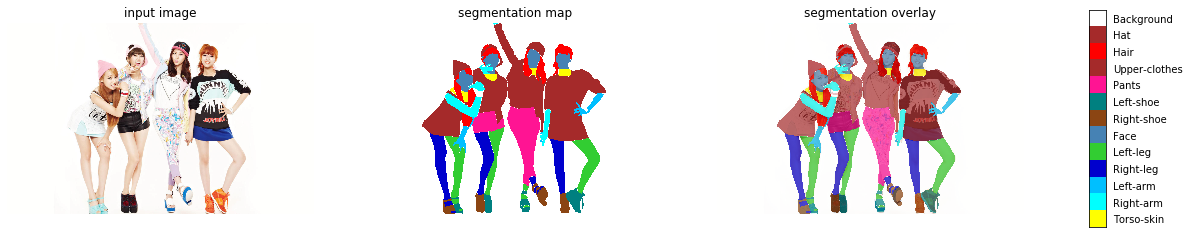

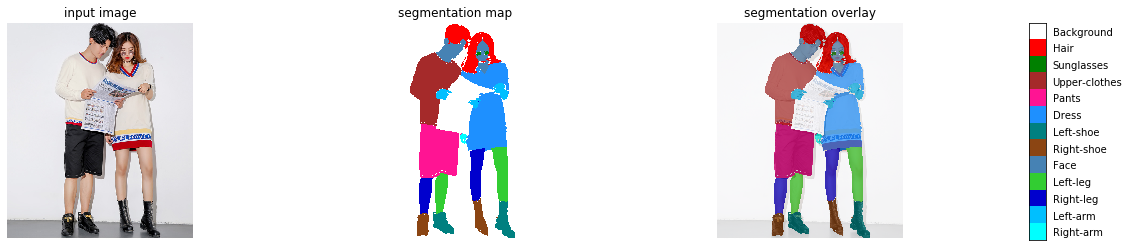

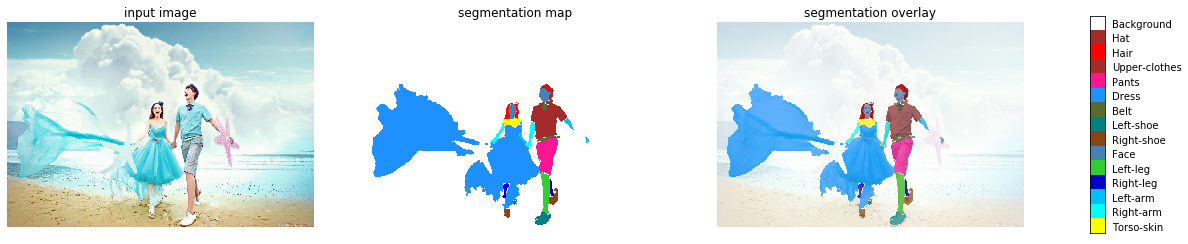

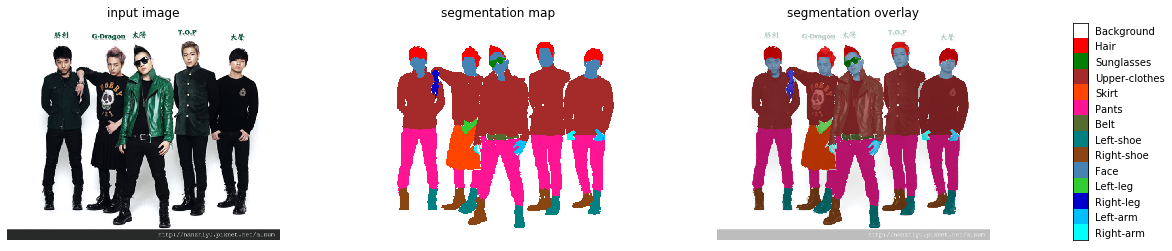

In [7]:
iters = 1
DN = DeNormalize(mean=[.485, .456, .406], std=[.229, .224, .225])
for i, (data, dsts) in enumerate(test_data):
    img = DN(data)
    img = img.asnumpy()[0, :, :, :]
    img = np.transpose(img, (1,2,0))
    label = mx.nd.squeeze(dsts).asnumpy()

    vis_segmentation(img, label)
    
    iters += 1
    if iters > 10:
        break

## Load the pre-trained PSPNet model and make prediction

In [35]:
model = 'psp'
backbone = 'resnet50'
ctx = mx.cpu(0)
norm_layer = mx.gluon.nn.BatchNorm
norm_kwargs = {}
aux = False

base_size = 768
crop_size = 768

resume = '/home/ubuntu/workspace/gluon-cv/scripts/segmentation/runs/mhp/psp/resnet50_sgd_0.0005_480/epoch_0042_mIoU_0.3424.params'


In [37]:
net = get_segmentation_model(
    model=model, dataset=dataset, ctx=ctx,backbone=backbone, 
)
net.load_parameters(resume, ctx=ctx, allow_missing=True)

self.crop_size 480


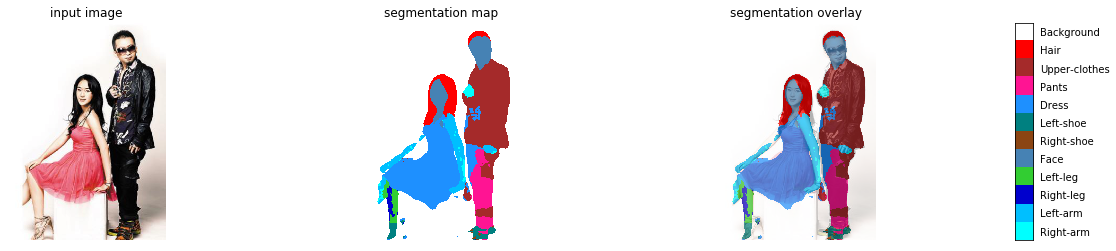

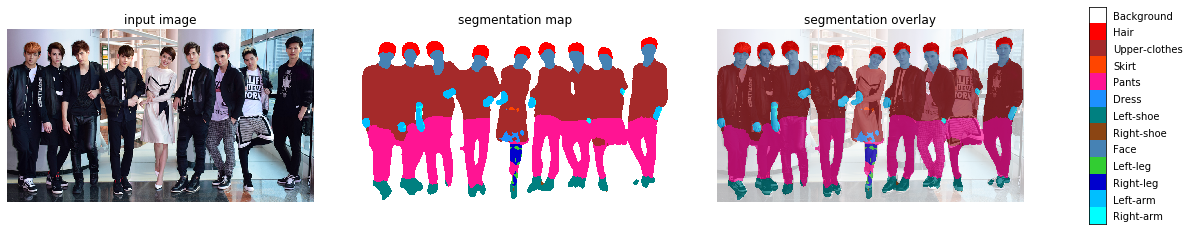

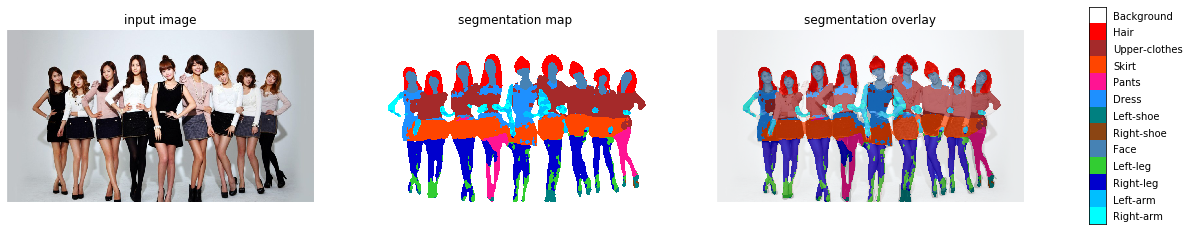

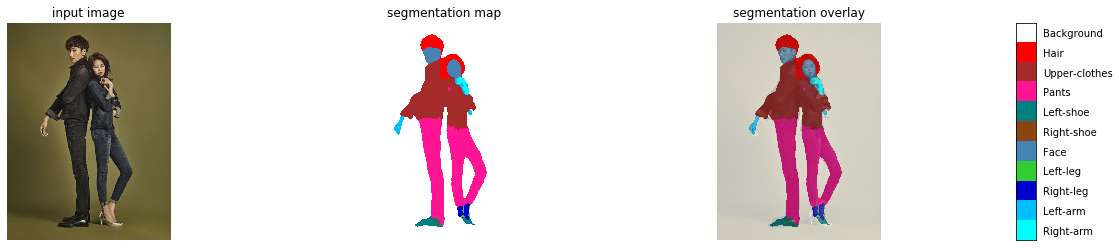

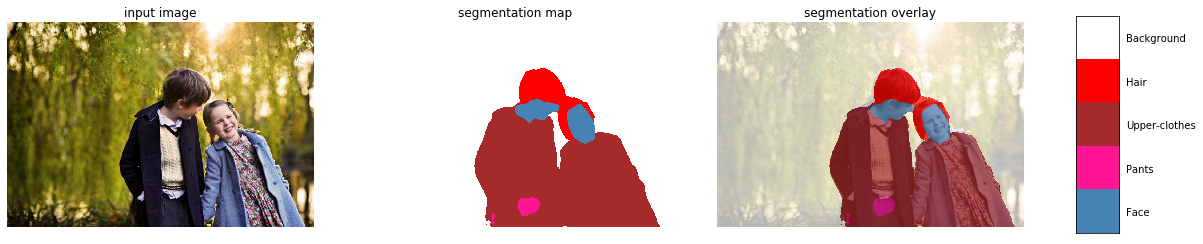

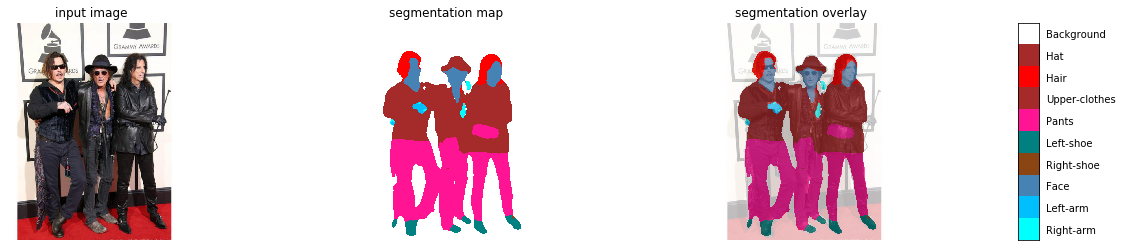

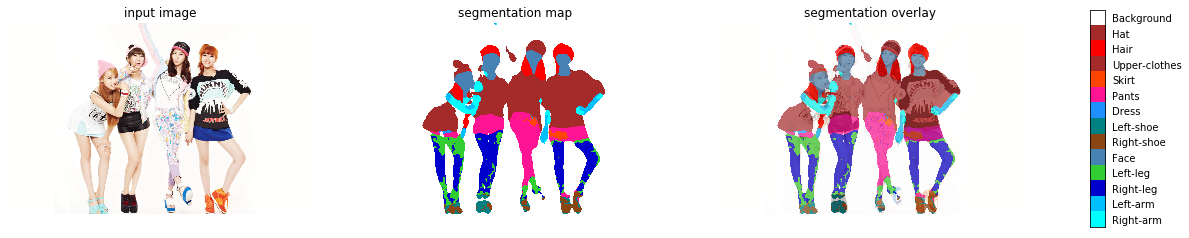

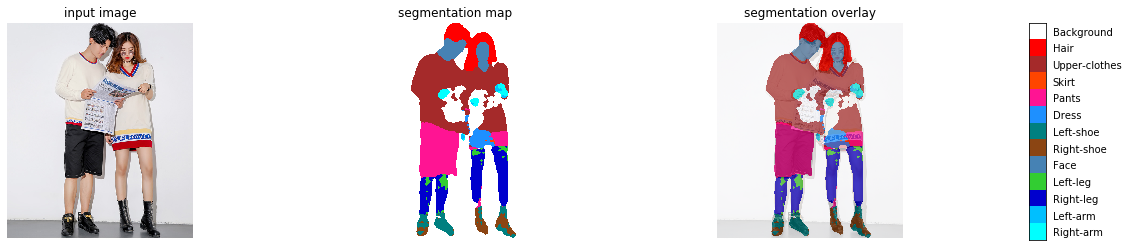

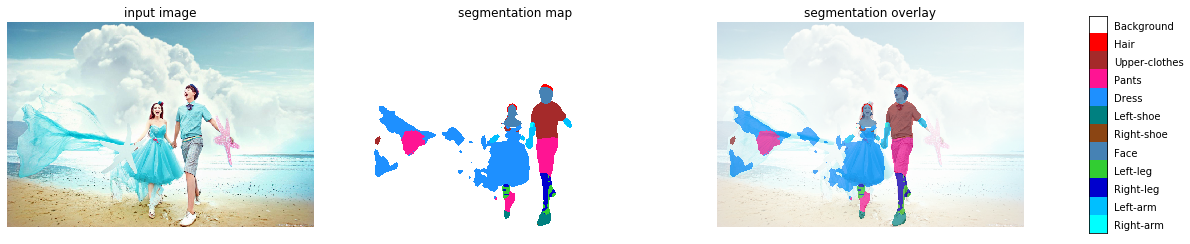

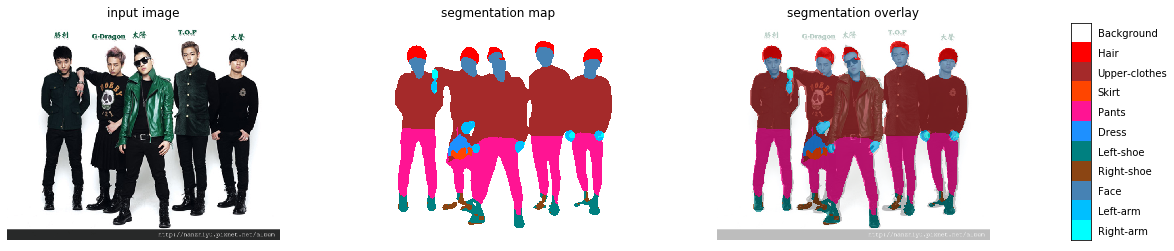

In [43]:
iters = 1

for i, (data, dsts) in enumerate(test_data):
    output = net.demo(data)
    predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
    predict = predict.astype(np.int)
    
    
    img = DN(data)
    img = img.asnumpy()[0, :, :, :]
    img = np.transpose(img, (1,2,0))
#     label = mx.nd.squeeze(dsts).asnumpy()

    vis_segmentation(img, predict)
    
    iters += 1
    if iters > 10:
        break